In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Colab Notebooks/bigdata

/content/drive/MyDrive/Colab Notebooks/bigdata


In [4]:
df = pd.read_csv('data.csv')
df.shape

(200092, 331)

## 取出基本資料column備用

In [5]:
col_info = ['CUST_LOCATION', 'AGE', 'GENDER', 'JOB', 'BRANCH_DIST']

## 對基本資料column前處理

* 資料型別轉換

In [6]:
df_use = df[['CUST_LOCATION', 'AGE', 'GENDER', 'JOB', 'BRANCH_DIST', 'AUM_M1', 'AUM_M13']].copy()
for i in col_info:
  df_use[i] = df_use[i].astype('category')
df_use[col_info].dtypes

CUST_LOCATION    category
AGE              category
GENDER           category
JOB              category
BRANCH_DIST      category
dtype: object

* AGE, JOB, BRANCHDIST有遺漏值，其中JOB的遺漏值問題很嚴重

In [7]:
df[col_info].isnull().sum()/df.shape[0]

CUST_LOCATION    0.000000
AGE              0.002369
GENDER           0.000000
JOB              0.476781
BRANCH_DIST      0.008686
dtype: float64

* 35 ~ 39, 40 ~ 44的人最多, 因遺漏值只佔整體資料的0.2%，因此將會直接使用這兩個年齡區間填入
* (抽一半填35 ~ 39，一半填40 ~ 44)

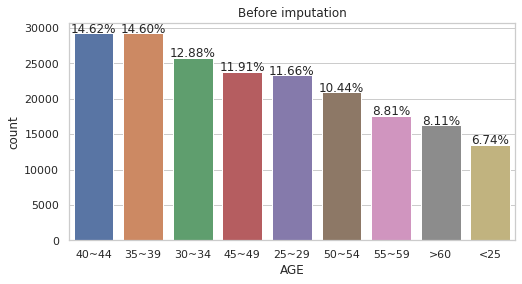

In [ ]:
sns.set(style = 'whitegrid')
plt.figure(figsize = (8, 4))
sns.countplot(df['AGE'], order = df.value_counts('AGE', ascending = False).index)
d = df['AGE'].value_counts()
for i in range(d.shape[0]):
  count = d.values[i]
  strt = '{:0.2f}%'.format(100*count/df.shape[0])
  plt.text(i, count+100, strt, ha='center')
plt.title('Before imputation')
plt.show()

In [8]:
age_null_index = list(df['AGE'][df['AGE'].isnull()].index)
print(f'AGE的遺漏值個數 = {len(age_null_index)}')

AGE的遺漏值個數 = 474


In [9]:
import random
random.seed(1)
age_fill_1 = random.sample(age_null_index, len(age_null_index))
age_fill_2 = [i for i in age_null_index if i not in age_fill_1]
df_use['AGE'][age_fill_1] = '35~39'
df_use['AGE'][age_fill_2] = '40~44'
df_use['AGE'].isnull().sum()

0

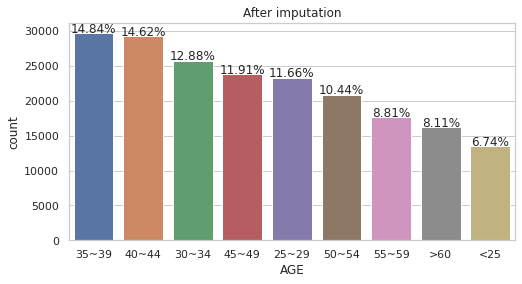

In [ ]:
plt.figure(figsize = (8, 4))
sns.countplot(df_use['AGE'], order = df_use.value_counts('AGE', ascending = False).index)
d = df_use['AGE'].value_counts()
for i in range(d.shape[0]):
  count = d.values[i]
  strt = '{:0.2f}%'.format(100*count/df_use.shape[0])
  plt.text(i, count+100, strt, ha='center')
plt.title('After imputation')
plt.show()

In [ ]:
df_use['AGE'] = df_use['AGE'].str.replace('~', '_')
df_use['AGE'] = df_use['AGE'].str.replace('>', '')
df_use['AGE'] = df_use['AGE'].str.replace('<', '')

* '>5km'的人最多, 因遺漏值只佔整體資料的0.8%，將會直接使用'>5km填入

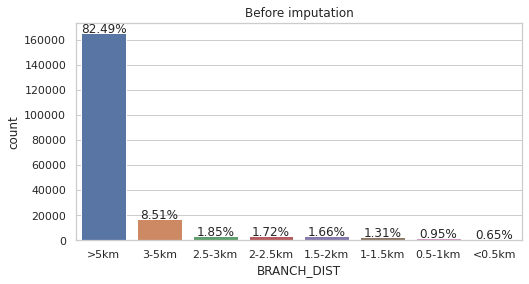

In [ ]:
df['BRANCH_DIST'] = df['BRANCH_DIST'].str.replace('公里', 'km')
df.loc[df['BRANCH_DIST'] == '5km以上', 'BRANCH_DIST'] = '>5km'
sns.set(style = 'whitegrid')
plt.figure(figsize = (8, 4))
sns.countplot(df['BRANCH_DIST'], order = df.value_counts('BRANCH_DIST', ascending = False).index)
d = df['BRANCH_DIST'].value_counts()
for i in range(d.shape[0]):
  count = d.values[i]
  strt = '{:0.2f}%'.format(100*count/df.shape[0])
  plt.text(i, count+100, strt, ha='center')
plt.title('Before imputation')
plt.show()

In [10]:
df_use['BRANCH_DIST'] = df_use['BRANCH_DIST'].str.replace('公里', 'km')
df_use.loc[df_use['BRANCH_DIST'] == '5km以上', 'BRANCH_DIST'] = '>5km'
df_use['BRANCH_DIST'] = df_use['BRANCH_DIST'].fillna('>5km')
df_use['BRANCH_DIST'] = df_use['BRANCH_DIST'].str.replace('>', '')
df_use['BRANCH_DIST'] = df_use['BRANCH_DIST'].str.replace('<', '')
df_use['BRANCH_DIST'].isnull().sum()

0

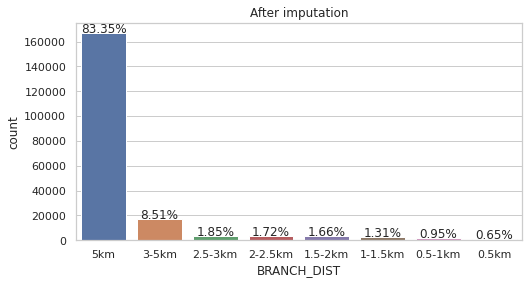

In [12]:
plt.figure(figsize = (8, 4))
sns.countplot(df_use['BRANCH_DIST'], order = df_use.value_counts('BRANCH_DIST', ascending = False).index)
d = df_use['BRANCH_DIST'].value_counts()
for i in range(d.shape[0]):
  count = d.values[i]
  strt = '{:0.2f}%'.format(100*count/df_use.shape[0])
  plt.text(i, count+100, strt, ha='center')
plt.title('After imputation')
plt.show()

* JOB2的人最多, 但因為遺漏值佔整體資料的47%，太多了，所以用sklearn的IterativeImputer
* package來源: https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer

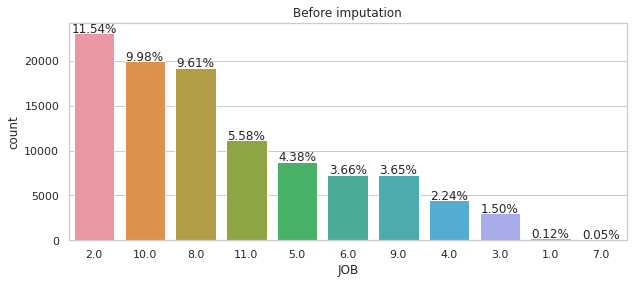

In [21]:
# sns.set(style = 'whitegrid')
# before_imp = df_use['JOB'].copy()
plt.figure(figsize = (10, 4))
sns.countplot(df_use['JOB'], order = df_use.value_counts('JOB', ascending = False).index)
d = df_use['JOB'].value_counts()
for i in range(d.shape[0]):
  count = d.values[i]
  strt = '{:0.2f}%'.format(100*count/df_use.shape[0])
  plt.text(i, count+100, strt, ha='center')
plt.title('After imputation')
plt.title('Before imputation')
plt.show()

* 先把其他類別變數encode

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder

labeled_info = df_use[col_info].copy()
labelencoder_1 = LabelEncoder()
labeled_info['CUST_LOCATION'] = labelencoder_1.fit_transform(labeled_info['CUST_LOCATION'])
labelencoder_2 = LabelEncoder()
labeled_info['AGE'] = labelencoder_2.fit_transform(labeled_info['AGE'])
labelencoder_3 = LabelEncoder()
labeled_info['GENDER'] = labelencoder_3.fit_transform(labeled_info['GENDER'])
labelencoder_4 = LabelEncoder()
labeled_info['BRANCH_DIST'] = labelencoder_4.fit_transform(labeled_info['BRANCH_DIST'].apply(lambda x: str(x)))

* impute

In [ ]:
imp = IterativeImputer(max_iter = 10, random_state = 1)
imp.fit(labeled_info)
labeled_info = imp.transform(labeled_info)
labeled_info[:, 3] = np.round(labeled_info[:, 3], 0) # 將impute結果四捨五入至整數
labeled_info = labeled_info.astype('int64') # 轉換資料型別(取indice才不會error))
df_use['JOB'] = labeled_info[:, 3]

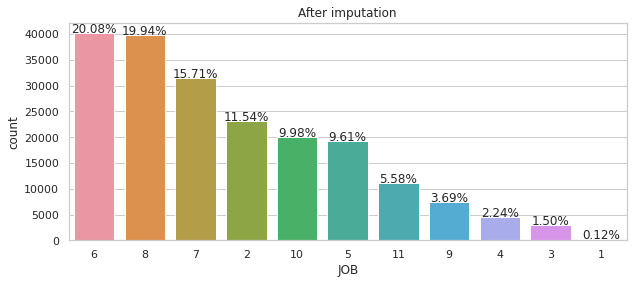

In [ ]:
plt.figure(figsize = (10, 4))
sns.countplot(df_use['JOB'], order = df_use.value_counts('JOB', ascending = False).index)
plt.title('After imputation')
d = df_use['JOB'].value_counts()
for i in range(d.shape[0]):
  count = d.values[i]
  strt = '{:0.2f}%'.format(100*count/df_use.shape[0])
  plt.text(i, count+100, strt, ha='center')
plt.show()

* CUST_LOCATION

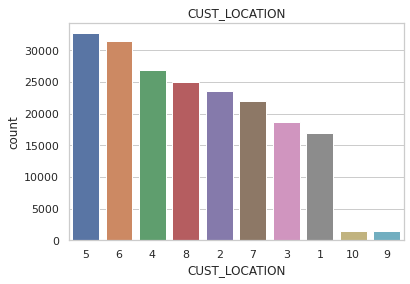

In [ ]:
sns.set(style = 'whitegrid')
plt.figure(figsize = (6, 4))
sns.countplot(df['CUST_LOCATION'], order = df.value_counts('CUST_LOCATION', ascending = False).index)
plt.title('CUST_LOCATION')
plt.show()

* GENDER

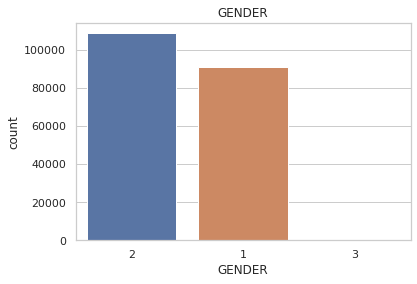

In [ ]:
sns.set(style = 'whitegrid')
plt.figure(figsize = (6, 4))
sns.countplot(df['GENDER'], order = df.value_counts('GENDER', ascending = False).index)
plt.title('GENDER')
plt.show()

## 各類基本資料與一年內資產變化(AUM_M13-AUM_M1)的關係
* col_info = ['CUST_LOCATION', 'AGE', 'GENDER', 'JOB', 'BRANCH_DIST']

In [ ]:
df_use['AUM_M13_M1'] = df_use['AUM_M13'] - df_use['AUM_M1']

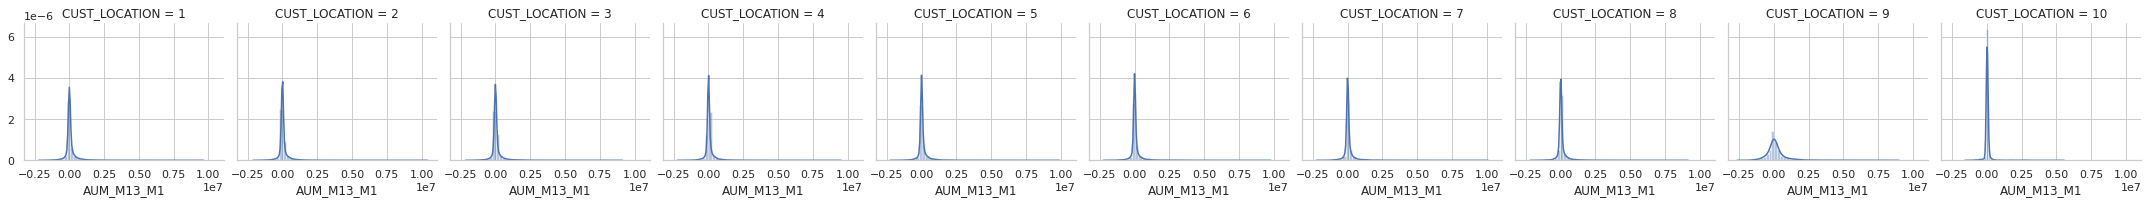

In [ ]:
g = sns.FacetGrid(df_use, col = 'CUST_LOCATION')
g = g.map(sns.distplot, 'AUM_M13_M1')

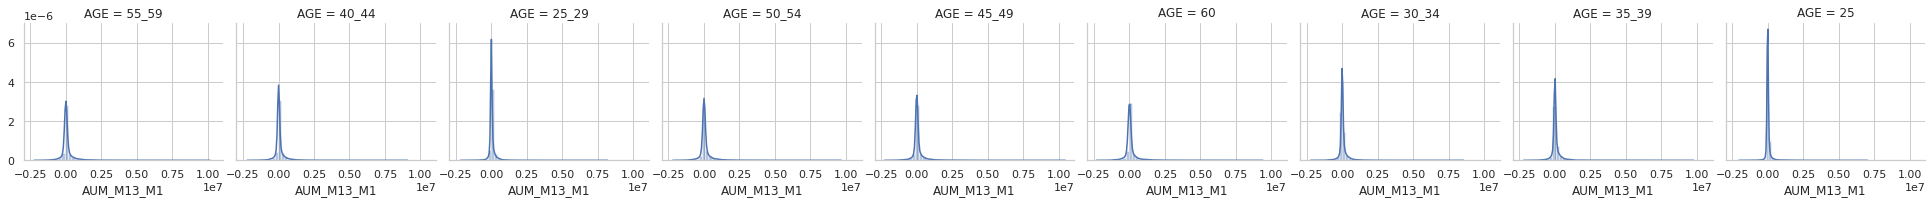

In [ ]:
g = sns.FacetGrid(df_use, col = 'AGE')
g = g.map(sns.distplot, 'AUM_M13_M1')

* 性別看起來和資產變化沒什麼關係

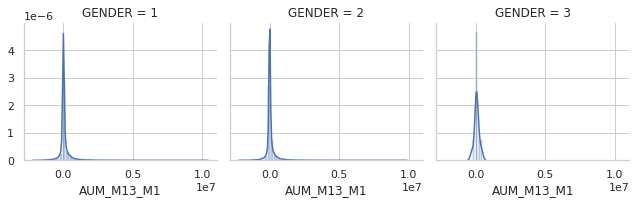

In [ ]:
g = sns.FacetGrid(df_use, col = 'GENDER')
g = g.map(sns.distplot, 'AUM_M13_M1')

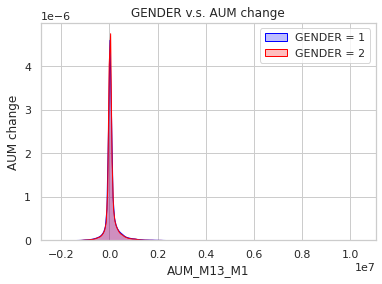

In [ ]:
plt.figure(figsize = (6, 4))
g = sns.kdeplot(df_use['AUM_M13_M1'][df_use['GENDER'] == 1], color = 'Blue', shade = True)
g = sns.kdeplot(df_use['AUM_M13_M1'][df_use['GENDER'] == 2], ax = g, color = 'Red', shade= True)
g.set_xlabel('AUM_M13_M1')
g.set_ylabel('AUM change')
plt.title('GENDER v.s. AUM change')
g = g.legend(['GENDER = 1', 'GENDER = 2'])

* 與分行距離看起來和資產變化有關，但此類別分布極不平均，應該沒什麼參考價值


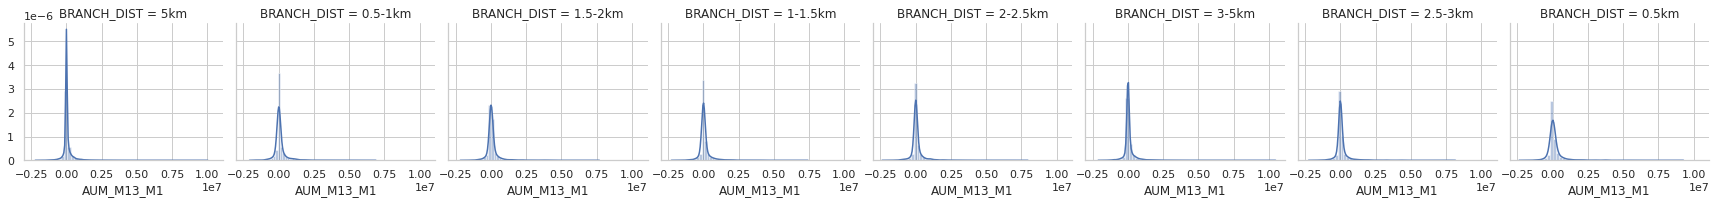

In [ ]:
g = sns.FacetGrid(df_use, col = 'BRANCH_DIST')
g = g.map(sns.distplot, 'AUM_M13_M1')

## 對類別變數編碼

In [ ]:
onehot = ['CUST_LOCATION', 'AGE', 'GENDER', 'JOB', 'BRANCH_DIST']
for f in onehot:
    df_use_dummy = pd.get_dummies(df_use[f], prefix = f)
    df_use = df_use.drop([f], axis = 1 )
    df_use = pd.concat((df_use, df_use_dummy), axis = 1)

In [ ]:
df_use.columns

Index(['AUM_M1', 'AUM_M13', 'CUST_LOCATION_1', 'CUST_LOCATION_2',
       'CUST_LOCATION_3', 'CUST_LOCATION_4', 'CUST_LOCATION_5',
       'CUST_LOCATION_6', 'CUST_LOCATION_7', 'CUST_LOCATION_8',
       'CUST_LOCATION_9', 'CUST_LOCATION_10', 'AGE_25', 'AGE_25_29',
       'AGE_30_34', 'AGE_35_39', 'AGE_40_44', 'AGE_45_49', 'AGE_50_54',
       'AGE_55_59', 'AGE_60', 'GENDER_1', 'GENDER_2', 'GENDER_3', 'JOB_1',
       'JOB_2', 'JOB_3', 'JOB_4', 'JOB_5', 'JOB_6', 'JOB_7', 'JOB_8', 'JOB_9',
       'JOB_10', 'JOB_11', 'BRANCH_DIST_0.5-1km', 'BRANCH_DIST_0.5km',
       'BRANCH_DIST_1-1.5km', 'BRANCH_DIST_1.5-2km', 'BRANCH_DIST_2-2.5km',
       'BRANCH_DIST_2.5-3km', 'BRANCH_DIST_3-5km', 'BRANCH_DIST_5km'],
      dtype='object')

In [ ]:
df_use = df_use.drop(['AUM_M1', 'AUM_M13'], axis = 1)
df_use.columns

Index(['CUST_LOCATION_1', 'CUST_LOCATION_2', 'CUST_LOCATION_3',
       'CUST_LOCATION_4', 'CUST_LOCATION_5', 'CUST_LOCATION_6',
       'CUST_LOCATION_7', 'CUST_LOCATION_8', 'CUST_LOCATION_9',
       'CUST_LOCATION_10', 'AGE_25', 'AGE_25_29', 'AGE_30_34', 'AGE_35_39',
       'AGE_40_44', 'AGE_45_49', 'AGE_50_54', 'AGE_55_59', 'AGE_60',
       'GENDER_1', 'GENDER_2', 'GENDER_3', 'JOB_1', 'JOB_2', 'JOB_3', 'JOB_4',
       'JOB_5', 'JOB_6', 'JOB_7', 'JOB_8', 'JOB_9', 'JOB_10', 'JOB_11',
       'BRANCH_DIST_0.5-1km', 'BRANCH_DIST_0.5km', 'BRANCH_DIST_1-1.5km',
       'BRANCH_DIST_1.5-2km', 'BRANCH_DIST_2-2.5km', 'BRANCH_DIST_2.5-3km',
       'BRANCH_DIST_3-5km', 'BRANCH_DIST_5km'],
      dtype='object')

In [ ]:
df_use.to_csv('info.csv', index = False)